# Arbolado IA
-------

### Paquetes
---

In [1]:
# ============================================
# General purpose
# ============================================
import json
import ast
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# ============================================
# Preprocessing & feature engineering
# ============================================
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# ============================================
# Train-test splitting & model selection
# ============================================
from sklearn.model_selection import (
    train_test_split
)


# ============================================
# Metrics
# ============================================
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Para remuestreo adicional
from sklearn.utils import resample
from sklearn.neighbors import KDTree


# ============================================
# Imbalanced-learn SMOTE
# ============================================
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

# ============================================
# Imbalanced-learn GAN
# ============================================
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# ============================================
# Clasificadores principales
# ============================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

### Carga de datos
----

In [7]:
# Carga de datos
df1 = pd.read_csv('./data-arbolado-junior.csv')
df1 = df1.drop(columns=['id'])
df2 = pd.read_csv('./data-arbolado-crisol.csv')
df2 = df2[~df2["estadoFitosanitario"].isin(["Bueno", "Regular"])]
df3 = pd.read_csv('./data-arbolado-gralpaz.csv')
df3 = df3[~df3["estadoFitosanitario"].isin(["Bueno", "Regular"])]

df = pd.concat([df1, df2, df3])

subset = df[df["estadoFitosanitario"].isin(["Bueno", "Regular"])]
subset_1000 = subset.sample(n=1000, random_state=42)
df = df.drop(subset_1000.index)

In [8]:
print("El tamaño del DataFrame es: \n")
print(f'Shape: {df.shape}')

df.head()

El tamaño del DataFrame es: 

Shape: (3382, 28)


,fecha,latitud,longitud,direccion,barrioNombre,altura,fuste,faseVital,estadoFitosanitario,inclinacion,...,intervenciones,distForestalAdecuada,interf,cazuela,levantamientoVereda,observaciones,especieNombre,lugarRelevamientoNombre,tipoLugarNombre,Observaciones
1,7/2/2018,-31.418807,-64.170212,916,Juniors,Entre 4m. y 7m.,"Entre 0,10m. y 0,40m.",Maduro,Regular,Leve,...,Mantenimiento,True,True,Adecuada,Leve,NaN,Siempre Verde,Americo Vespucio 900-1000,Calle,NaN
2,7/2/2018,-31.418807,-64.170161,924,Juniors,Menor a 4m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Crespón,Americo Vespucio 900-1000,Calle,NaN
3,7/2/2018,-31.418832,-64.170114,930,Juniors,Entre 7m. y 10m.,"Entre 0,10m. y 0,40m.",Maduro,Bueno,Leve,...,Mantenimiento,True,False,Franja Verde,No,NaN,Guaran Amarillo,Americo Vespucio 900-1000,Calle,NaN
4,7/2/2018,-31.418868,-64.169999,932,Juniors,Menor a 4m.,"Menor a 0,10m.",Maduro,Bueno,No,...,Mantenimiento,True,False,Franja Verde,No,NaN,Ficus Benjamina,Americo Vespucio 900-1000,Calle,NaN
5,7/2/2018,-31.418875,-64.169904,942,Juniors,Menor a 4m.,"Menor a 0,10m.",Joven,Regular,No,...,Sin intervenciones,True,False,Adecuada,No,NaN,Otra especie,Americo Vespucio 900-1000,Calle,NaN


In [9]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
Regular    1879
Bueno       305
Malo        292
Muerto       79
Name: count, dtype: int64

## Ingeniería de Datos
----

In [10]:
cols_to_drop = [
    "fecha", "latitud", "longitud", "direccion", 
    "barrioNombre", "observaciones", "lugarRelevamientoNombre", 
    "tipoLugarNombre", "Observaciones", "especieNombre"
]
df = df.drop(columns=cols_to_drop)

In [11]:
print(df.columns)

Index(['altura', 'fuste', 'faseVital', 'estadoFitosanitario', 'inclinacion',
       'ahuecamiento', 'problemaDesrames', 'problemaDescalzado',
       'problemaFustePartido', 'problemaObjetoExtranio', 'problemaGrieta',
       'problemaDesequilibrioCopa', 'manejoInadecuado', 'intervenciones',
       'distForestalAdecuada', 'interf', 'cazuela', 'levantamientoVereda'],
      dtype='object')


### DataFrame discreto
---

In [12]:
filas_con_nan = df.isna().any(axis=1)

# Cantidad de filas con al menos un dato vacío
print(f"Filas con al menos un NaN: {filas_con_nan.sum()}")

# Filtrar esas filas
df = df[~df.isna().any(axis=1)].copy()

Filas con al menos un NaN: 827


In [13]:
label_maps = {}

le = LabelEncoder()

for col in df.columns:
    # Ignora columnas completamente vacías
    if df[col].dropna().empty:
        continue

    first_val = df[col].dropna().iloc[0]

    # Columnas booleanas (True/False)
    if isinstance(first_val, bool):
        df[col] = df[col].astype('boolean').fillna(False).astype(int)


In [14]:
altura_map = {
    'Menor a 4m.': 0,
    'Entre 4m. y 7m.': 1,
    'Entre 7m. y 10m.': 2,
    'Mayor a 10m': 3,
    'Entre 10m. y 18m.': 4,
    'Mayor a 18m.': 5
}

fuste_map = {
    'Menor a 0,10m.': 0,
    'Entre 0,10m. y 0,40m.': 1,
    'Entre 0,40m. y 0,80m.': 2,
    'Mayor 0,40m': 2,
    'Mayor 0,80m': 3
}

faseVital_map = {
    'Recién implantado': 0,
    'Joven': 1,
    'Maduro': 2,
    'Añoso': 3,
    'Decrépito': 4
}

estadoFitosanitario_map = {
    'Bueno': 0,
    'Regular': 1,
    'Malo': 2,
    'Muerto': 3
}

inclinacion_map = {
    'No': 0,
    'Leve': 1,
    'Severa': 2
}

ahuecamiento_map = {
    'No': 0,
    'Leve': 1,
    'Moderado': 2,
    'Severo': 3
}

manejoInadecuado_map = {
    'No': 0,
    'Leve': 1,
    'Severo': 2
}

levantamientoVereda_map = {
    'No': 0,
    'Leve': 1,
    'Considerable': 2
}

cazuela_map = {
    'Adecuada': 0,
    'Franja Verde': 1,      # ¿Es mejor o peor? Ajusta según criterio
    'Inadecuada': 2
}

# Intervenciones: depende del objetivo (¿Tala es peor?)
intervenciones_map = {
    'Sin intervenciones': 0,
    'Mantenimiento': 1,
    'Raíces': 2,
    'Despunte': 3,
    'Descopado': 4,
    'Varias intervenciones': 5,
    'Total': 6,
    'Tala': 7
}

# Aplicar todos los mapeos
df['altura'] = df['altura'].map(altura_map)
df['fuste'] = df['fuste'].map(fuste_map)
df['faseVital'] = df['faseVital'].map(faseVital_map)
df['estadoFitosanitario'] = df['estadoFitosanitario'].map(estadoFitosanitario_map)
df['inclinacion'] = df['inclinacion'].map(inclinacion_map)
df['ahuecamiento'] = df['ahuecamiento'].map(ahuecamiento_map)
df['manejoInadecuado'] = df['manejoInadecuado'].map(manejoInadecuado_map)
df['intervenciones'] = df['intervenciones'].map(intervenciones_map)
df['cazuela'] = df['cazuela'].map(cazuela_map)
df['levantamientoVereda'] = df['levantamientoVereda'].map(levantamientoVereda_map)

# Actualizar label_maps
label_maps.update({
    'altura': altura_map,
    'fuste': fuste_map,
    'estadoFitosanitario': estadoFitosanitario_map,
    'inclinacion': inclinacion_map,
    'ahuecamiento': ahuecamiento_map,
    'manejoInadecuado': manejoInadecuado_map,
    'intervenciones': intervenciones_map,
    'levantamientoVereda': levantamientoVereda_map,
    'faseVital': faseVital_map
})


In [15]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    1879
0     305
2     292
3      79
Name: count, dtype: int64

In [17]:
path = "./label_maps.json"
with open(path, "w", encoding="utf-8") as f:
    json.dump(label_maps, f, ensure_ascii=False, indent=2)

path

'./label_maps.json'

## Entrenamiento - 4 clases
----

### XGBoost - Classifier
---

Accuracy: 0.7436399217221135

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.39      0.42        61
           1       0.80      0.91      0.85       376
           2       0.43      0.17      0.25        58
           3       0.50      0.31      0.38        16

    accuracy                           0.74       511
   macro avg       0.55      0.45      0.48       511
weighted avg       0.71      0.74      0.72       511



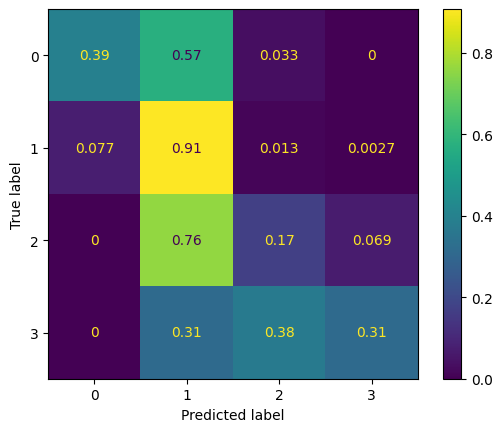

In [258]:
# Features (todas menos la columna objetivo)
X = df.drop("estadoFitosanitario", axis=1)

# Target (asegurarse de que sea entero)
y = df["estadoFitosanitario"].astype(int)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Definir modelo XGBoost para clasificación
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Entrenar
xgb_clf.fit(X_train, y_train)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2,3])
disp_pre.plot()


Para solventar el desbalanceo de clases que tienen los datos, primero vamos a optar por submuestreo de las clases mayoritarias, es este caso `Regular` y `Bueno`

Accuracy: 0.7240704500978473

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.48      0.43        61
           1       0.81      0.85      0.83       376
           2       0.54      0.24      0.33        58
           3       0.43      0.38      0.40        16

    accuracy                           0.72       511
   macro avg       0.54      0.49      0.50       511
weighted avg       0.72      0.72      0.71       511



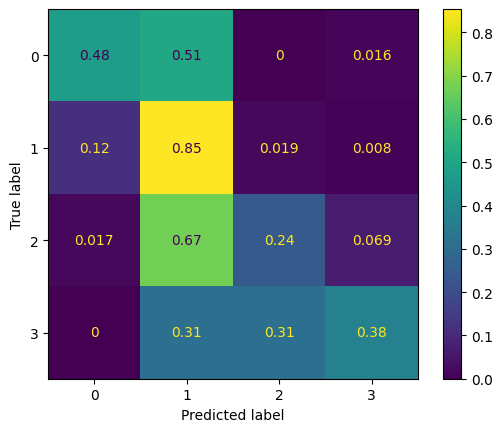

In [259]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)

# ---- Balancear SOLO el conjunto de entrenamiento ----
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# ---- Definir y entrenar modelo ----
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

xgb_clf.fit(X_train_res, y_train_res)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2,3])
disp_pre.plot()

Ahora analicemos un sobremuestreo de las clases minoritarias

Accuracy: 0.6790606653620352

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.34      0.40        61
           1       0.81      0.80      0.81       376
           2       0.30      0.34      0.32        58
           3       0.18      0.38      0.24        16

    accuracy                           0.68       511
   macro avg       0.45      0.47      0.44       511
weighted avg       0.70      0.68      0.69       511



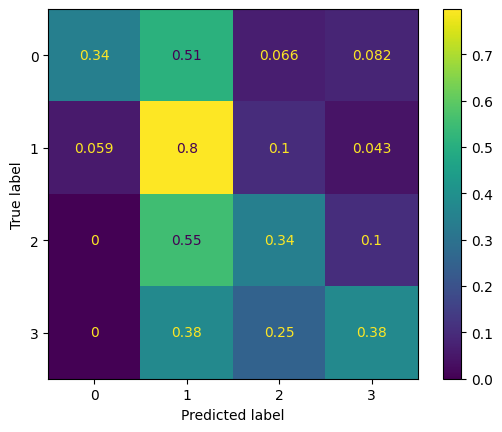

In [260]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2,3])
disp_pre.plot()

### Random Foresft - Classifier
---

Accuracy: 0.6360078277886497

Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.54      0.45        61
           1       0.82      0.70      0.76       376
           2       0.25      0.33      0.28        58
           3       0.30      0.50      0.37        16

    accuracy                           0.64       511
   macro avg       0.44      0.52      0.47       511
weighted avg       0.69      0.64      0.66       511



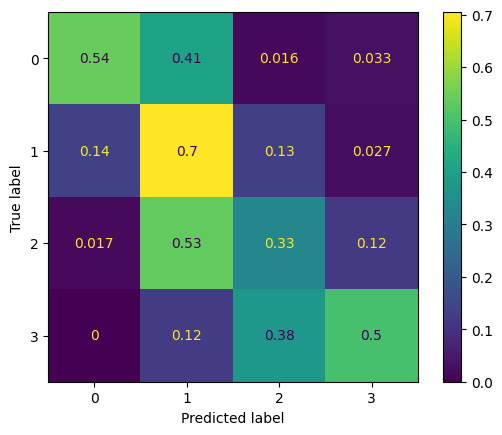

In [261]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.5968688845401174

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.57      0.42        61
           1       0.82      0.66      0.73       376
           2       0.24      0.31      0.27        58
           3       0.18      0.31      0.23        16

    accuracy                           0.60       511
   macro avg       0.39      0.46      0.41       511
weighted avg       0.67      0.60      0.62       511



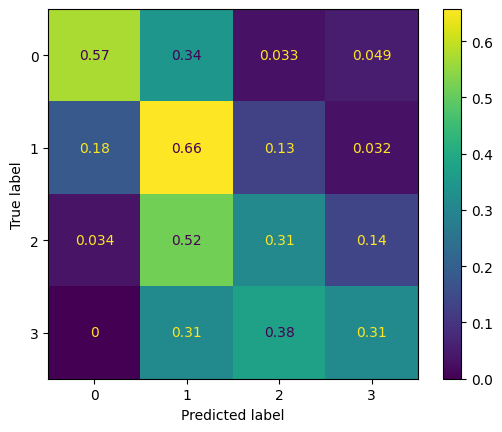

In [262]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]
X_train_3 = X_train[y_train == 3]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]
y_train_3 = y_train[y_train == 3]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

X_train_3_up, y_train_3_up = resample(X_train_3, y_train_3,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up, X_train_3_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up, y_train_3_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2,3])
disp_pre.plot()

## Entrenamiento - 3 clases
----

### XGBoost - Classifier
---

In [263]:
df["estadoFitosanitario"] = df["estadoFitosanitario"].replace({2: 2, 3: 2})


In [264]:
df["estadoFitosanitario"].value_counts()

estadoFitosanitario
1    1879
2     371
0     305
Name: count, dtype: int64

Accuracy: 0.7573385518590998

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.41      0.43        61
           1       0.84      0.84      0.84       376
           2       0.57      0.62      0.60        74

    accuracy                           0.76       511
   macro avg       0.62      0.62      0.62       511
weighted avg       0.76      0.76      0.76       511



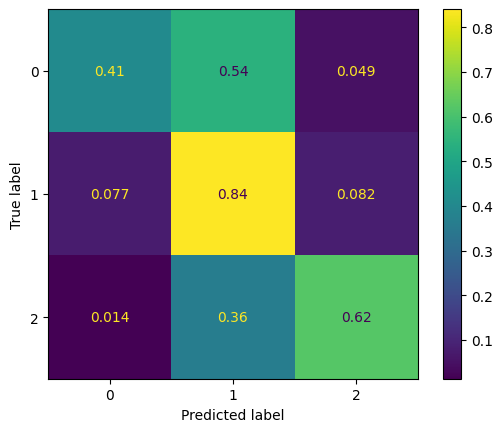

In [265]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()

### Random Forest - Classifier
---

Accuracy: 0.726027397260274

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.56      0.47        61
           1       0.85      0.77      0.81       376
           2       0.55      0.64      0.59        74

    accuracy                           0.73       511
   macro avg       0.60      0.65      0.62       511
weighted avg       0.75      0.73      0.74       511



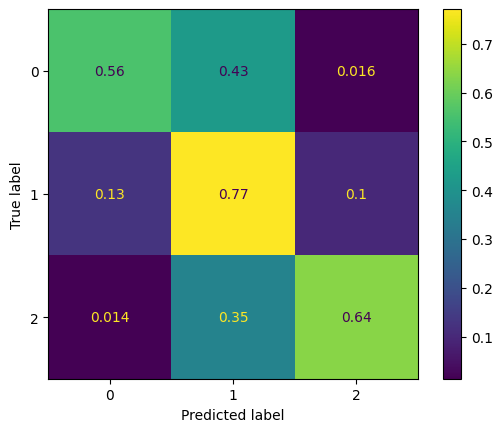

In [266]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]

# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)


# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # esto equilibra automáticamente las clases
)

# 3Entrenar
rf_clf.fit(X_train_aug, y_train_aug)

# 4Predecir
y_pred = rf_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier
---

Accuracy: 0.6731898238747553

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.61      0.42        61
           1       0.83      0.71      0.77       376
           2       0.53      0.53      0.53        74

    accuracy                           0.67       511
   macro avg       0.56      0.62      0.57       511
weighted avg       0.73      0.67      0.69       511



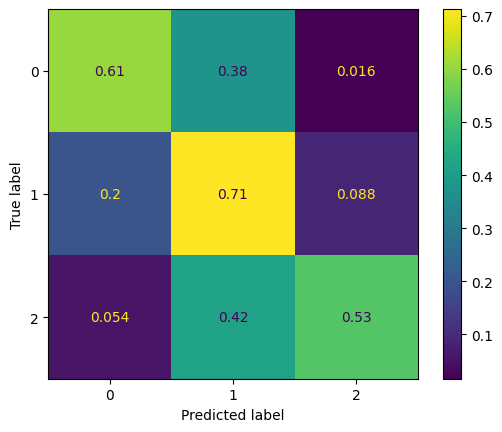

In [267]:
# Features y target
X = df.drop("estadoFitosanitario", axis=1)
y = df["estadoFitosanitario"].astype(int)

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1]
X_train_2 = X_train[y_train == 2]

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]
y_train_2 = y_train[y_train == 2]


# Sobremuestrear clases 2 y 3 (por ejemplo, igualarlas a clase 0)
X_train_2_up, y_train_2_up = resample(X_train_2, y_train_2,
                                      replace=True,
                                      n_samples=len(y_train_1),
                                      random_state=42)

# Combinar todo
X_train_aug = pd.concat([X_train_0, X_train_1, X_train_2_up])
y_train_aug = pd.concat([y_train_0, y_train_1, y_train_2_up])

# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    class_weight='balanced',  # rebalancea automáticamente las clases
    max_depth=None  # puedes ajustar para evitar overfitting
)

# Entrenar
dt_clf.fit(X_train_aug, y_train_aug)

# Predecir
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

Ideas de Aumentación de datos:

- Autoencoder 
- GAN


## Rebalanceo de Clases - SMOTE
---

### SMOTE

In [268]:
X = df.drop('estadoFitosanitario', axis=1)
y = df['estadoFitosanitario']

print("Distribución original:")
print(y.value_counts().sort_index())
print("-" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smoten = SMOTE(
    sampling_strategy='auto',  # balancea a la clase mayoritaria
    random_state=42,
    k_neighbors=5
)

X_train_res, y_train_res = smoten.fit_resample(X_train, y_train)

df_train_balanced = pd.DataFrame(X_train_res, columns=X_train.columns)
df_train_balanced['estadoFitosanitario'] = y_train_res

print("Distribución después de SMOTEN (solo train):")
print(df_train_balanced['estadoFitosanitario'].value_counts().sort_index())
print("-" * 50)
print(f"Tamaño train original: {len(X_train)}    tamaño train balanceado: {len(df_train_balanced)}")
print(f"Tamaño test (sin tocar): {len(X_test)}")

Distribución original:
estadoFitosanitario
0     305
1    1879
2     371
Name: count, dtype: int64
--------------------------------------------------
Distribución después de SMOTEN (solo train):
estadoFitosanitario
0    1503
1    1503
2    1503
Name: count, dtype: int64
--------------------------------------------------
Tamaño train original: 2044    tamaño train balanceado: 4509
Tamaño test (sin tocar): 511


### XGBoost

Accuracy: 0.7162426614481409

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.61      0.46        61
           1       0.87      0.76      0.81       376
           2       0.55      0.61      0.58        74

    accuracy                           0.72       511
   macro avg       0.59      0.66      0.61       511
weighted avg       0.76      0.72      0.73       511



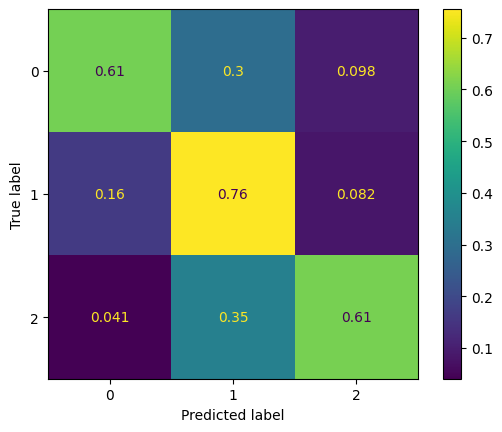

In [269]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    enable_categorical=True,   # <-- activa el manejo nativo
    n_jobs=-1
)

xgb_clf.fit(X_train_res, y_train_res)
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()                                                              

### Random Forest

Accuracy: 0.675146771037182

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.61      0.44        61
           1       0.86      0.69      0.77       376
           2       0.47      0.64      0.54        74

    accuracy                           0.68       511
   macro avg       0.56      0.65      0.58       511
weighted avg       0.74      0.68      0.70       511



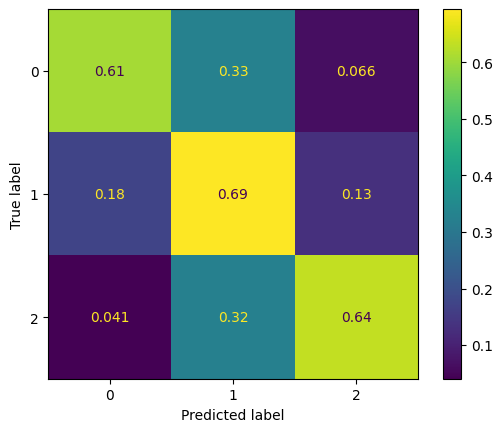

In [270]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_res, y_train_res)
y_pred = rf_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier

Accuracy: 0.6575342465753424

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.59      0.41        61
           1       0.82      0.71      0.76       376
           2       0.45      0.43      0.44        74

    accuracy                           0.66       511
   macro avg       0.53      0.58      0.54       511
weighted avg       0.71      0.66      0.67       511



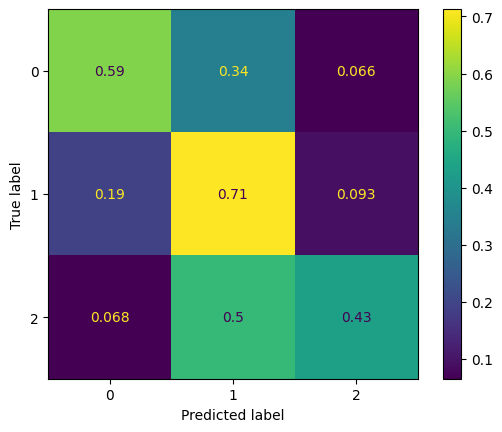

In [271]:
# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=None  # puedes ajustar para evitar overfitting
)
dt_clf.fit(X_train_res, y_train_res)
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Gradient Boosting

Accuracy: 0.7103718199608611

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.56      0.44        61
           1       0.86      0.75      0.80       376
           2       0.52      0.64      0.57        74

    accuracy                           0.71       511
   macro avg       0.58      0.65      0.61       511
weighted avg       0.75      0.71      0.72       511



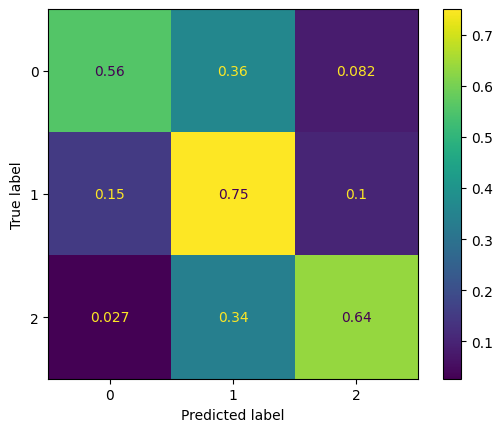

In [272]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_clf.fit(X_train_res, y_train_res)
y_pred = gb_clf.predict(X_test)
# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()

## Rebalanceo de Clases - GAN
---

### GAN

In [304]:
def filter_synthetic_by_nn(X_min, synthetic_inv, n_to_generate, random_state=42):
    """
    Devuelve las n_to_generate muestras sintéticas más cercanas al cloud real X_min.
    - X_min: (n_real, d) numpy array reales
    - synthetic_inv: (n_gen_raw, d) numpy array sintéticos (misma escala/feature order)
    - n_to_generate: int (cuántas quedarnos)
    """
    rng = np.random.default_rng(random_state)

    # protección: si no hay sintéticos suficientes, devolver todo (y advertir)
    n_gen_raw = synthetic_inv.shape[0]
    if n_gen_raw == 0:
        return np.empty((0, synthetic_inv.shape[1])), np.array([])

    if n_gen_raw < n_to_generate:
        # advertencia y retorno de todo
        print(f"[warning] sólo {n_gen_raw} sintéticos disponibles < n_to_generate={n_to_generate}. Se devolverán todos.")
        return synthetic_inv.copy(), np.arange(n_gen_raw)

    # construir KDTree sobre los reales
    tree = KDTree(X_min)

    # query: distancia a NN real más cercano para cada synthetic
    dists, idxs = tree.query(synthetic_inv, k=1)   # shapes (n_gen_raw,1)
    dists = dists.ravel()                          # (n_gen_raw,)

    # ordenar por distancia ascendente y quedarse con las n_to_generate menores
    order = np.argsort(dists)                      # indices ordenados
    keep_idx = order[:n_to_generate]

    # opcional: barajar los elegidos para evitar sesgos de orden
    rng.shuffle(keep_idx)

    chosen_synt = synthetic_inv[keep_idx]
    chosen_dists = dists[keep_idx]

    return chosen_synt, keep_idx

In [305]:
# --- parámetros ---
label_col = 'estadoFitosanitario'
minority_label = 2   # etiqueta que quieres aumentar (ajustar si hace falta)
n_epochs = 2000
batch_size = 64
latent_dim = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [306]:
X = df.drop(columns=[label_col])
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df_train = X_train.copy()
df_train[label_col] = y_train.values

num_cols = df_train.select_dtypes(include=[np.number]).columns.drop(label_col).tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Train sizes por clase (antes):")
print(df_train[label_col].value_counts())

Train sizes por clase (antes):
estadoFitosanitario
1    1503
2     297
0     244
Name: count, dtype: int64


In [307]:
if len(cat_cols) == 0:
    df_min = df_train[df_train[label_col] == minority_label].reset_index(drop=True)
    X_min = df_min.drop(columns=[label_col])[num_cols].values.astype(np.float32)

    # decidir cuántas generar con respecto al train (no al dataset completo)
    n_major_train = df_train[label_col].value_counts().max()
    n_to_generate = max(0, n_major_train - len(df_min))
    print(f"Minority examples in TRAIN: {len(df_min)}. Target to generate: {n_to_generate}")

    # escalado [-1,1] (coincide con tanh del generator)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    if len(X_min) > 0:
        X_min_scaled = scaler.fit_transform(X_min).astype(np.float32)
    else:
        X_min_scaled = np.empty((0, len(num_cols)), dtype=np.float32)

    n_features = len(num_cols)

Minority examples in TRAIN: 297. Target to generate: 1206


In [308]:
class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator(latent_dim, n_features).to(device)
D = Discriminator(n_features).to(device)

criterion = nn.BCELoss()
opt_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))

real_data = torch.tensor(X_min_scaled, dtype=torch.float32).to(device)

In [309]:
# --------------------------
# ENTRENAMIENTO
# --------------------------
n_real = real_data.size(0)
steps_per_epoch = max(1, n_real // batch_size) if n_real>0 else 1

for epoch in range(1, n_epochs + 1):
    if n_real == 0:
        break  # nada que entrenar si no hay ejemplos minoritarios en train
    for _ in range(steps_per_epoch):
        # --- entrenar D ---
        idx = np.random.randint(0, n_real, size=batch_size)
        real_batch = real_data[idx]

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_batch = G(z)

        real_labels = torch.ones(batch_size, 1, device=device) * 0.9
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --- entrenar G ---
        z = torch.randn(batch_size, latent_dim, device=device)
        gen = G(z)
        pred = D(gen)
        loss_G = criterion(pred, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"\rEpoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}", end="", flush=True)

Epoch 2000/2000 | loss_D: 0.7396 | loss_G: 1.7301

In [310]:
if n_to_generate > 0 and n_real > 0:
    n_generate_raw = max(int(3 * n_to_generate), n_to_generate)

    G.eval()
    with torch.no_grad():
        z = torch.randn(n_generate_raw, latent_dim, device=device)
        synthetic = G(z).cpu().numpy()

    synthetic_inv = scaler.inverse_transform(synthetic)

    chosen_synt, keep_idx = filter_synthetic_by_nn(X_min, synthetic_inv, n_to_generate, random_state=42)

    if chosen_synt.shape[0] < n_to_generate:
        all_idx = np.arange(synthetic_inv.shape[0])
        remaining_idx = np.setdiff1d(all_idx, keep_idx, assume_unique=True)
        need = n_to_generate - chosen_synt.shape[0]

        extra = np.empty((0, synthetic_inv.shape[1]))
        if remaining_idx.size > 0:
            take = min(need, remaining_idx.size)
            extra = synthetic_inv[remaining_idx[:take]]
            need -= take

        if need > 0:
            if chosen_synt.shape[0] > 0:
                rnd_idx = np.random.default_rng(42).integers(0, chosen_synt.shape[0], size=need)
                extra2 = chosen_synt[rnd_idx]
            else:

                rnd_idx = np.random.default_rng(42).integers(0, synthetic_inv.shape[0], size=need)
                extra2 = synthetic_inv[rnd_idx]
            extra = np.vstack([extra, extra2]) if extra.size else extra2

        # concatenar chosen + extra para alcanzar n_to_generate
        if chosen_synt.size:
            final_synt = np.vstack([chosen_synt, extra])
        else:
            final_synt = extra
    else:
        final_synt = chosen_synt

    # diagnóstico rápido: distancia media a reals de los seleccionados
    if final_synt.size:
        tree = KDTree(X_min)
        dists_sel, _ = tree.query(final_synt, k=1)
        mean_nn_dist = float(dists_sel.mean())
        print(f"Generated raw: {n_generate_raw}, selected: {final_synt.shape[0]}, mean NN dist (selected->real): {mean_nn_dist:.6f}")
    else:
        print("Warning: no synthetic samples selected after filtering.")

    # construir dataframe sintético y concatenar SOLO al train
    df_synthetic = pd.DataFrame(final_synt, columns=num_cols)
    df_synthetic[label_col] = minority_label

    df_train_balanced = pd.concat([df_train, df_synthetic], ignore_index=True)

else:
    df_train_balanced = df_train.copy()


Generated raw: 3618, selected: 1206, mean NN dist (selected->real): 0.652946


In [311]:
print("Train sizes por clase (antes):")
print(df_train_balanced[label_col].value_counts())

Train sizes por clase (antes):
estadoFitosanitario
1    1503
2    1503
0     244
Name: count, dtype: int64


In [312]:
# --- parámetros ---
label_col = 'estadoFitosanitario'
minority_label = 0   # etiqueta que quieres aumentar (ajustar si hace falta)
n_epochs = 2000
batch_size = 64
latent_dim = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [313]:
X = df.drop(columns=[label_col])
y = df[label_col]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

df_train = X_train.copy()
df_train[label_col] = y_train.values

num_cols = df_train.select_dtypes(include=[np.number]).columns.drop(label_col).tolist()
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Train sizes por clase (antes):")
print(df_train[label_col].value_counts())

Train sizes por clase (antes):
estadoFitosanitario
1    1503
2     297
0     244
Name: count, dtype: int64


In [314]:
if len(cat_cols) == 0:
    df_min = df_train[df_train[label_col] == minority_label].reset_index(drop=True)
    X_min = df_min.drop(columns=[label_col])[num_cols].values.astype(np.float32)

    # decidir cuántas generar con respecto al train (no al dataset completo)
    n_major_train = df_train[label_col].value_counts().max()
    n_to_generate = max(0, n_major_train - len(df_min))
    print(f"Minority examples in TRAIN: {len(df_min)}. Target to generate: {n_to_generate}")

    # escalado [-1,1] (coincide con tanh del generator)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    if len(X_min) > 0:
        X_min_scaled = scaler.fit_transform(X_min).astype(np.float32)
    else:
        X_min_scaled = np.empty((0, len(num_cols)), dtype=np.float32)

    n_features = len(num_cols)

Minority examples in TRAIN: 244. Target to generate: 1259


In [315]:
# --------------------------
# ENTRENAMIENTO
# --------------------------
n_real = real_data.size(0)
steps_per_epoch = max(1, n_real // batch_size) if n_real>0 else 1

for epoch in range(1, n_epochs + 1):
    if n_real == 0:
        break  # nada que entrenar si no hay ejemplos minoritarios en train
    for _ in range(steps_per_epoch):
        # --- entrenar D ---
        idx = np.random.randint(0, n_real, size=batch_size)
        real_batch = real_data[idx]

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_batch = G(z)

        real_labels = torch.ones(batch_size, 1, device=device) * 0.9
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_real = D(real_batch)
        D_fake = D(fake_batch.detach())

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # --- entrenar G ---
        z = torch.randn(batch_size, latent_dim, device=device)
        gen = G(z)
        pred = D(gen)
        loss_G = criterion(pred, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if epoch % 100 == 0 or epoch == 1:
        print(f"\rEpoch {epoch}/{n_epochs} | loss_D: {loss_D.item():.4f} | loss_G: {loss_G.item():.4f}", end="", flush=True)

Epoch 2000/2000 | loss_D: 0.6507 | loss_G: 1.9537

In [316]:
if n_to_generate > 0 and n_real > 0:
    n_generate_raw = max(int(3 * n_to_generate), n_to_generate)

    G.eval()
    with torch.no_grad():
        z = torch.randn(n_generate_raw, latent_dim, device=device)
        synthetic = G(z).cpu().numpy()

    synthetic_inv = scaler.inverse_transform(synthetic)

    chosen_synt, keep_idx = filter_synthetic_by_nn(X_min, synthetic_inv, n_to_generate, random_state=42)

    if chosen_synt.shape[0] < n_to_generate:
        all_idx = np.arange(synthetic_inv.shape[0])
        remaining_idx = np.setdiff1d(all_idx, keep_idx, assume_unique=True)
        need = n_to_generate - chosen_synt.shape[0]

        extra = np.empty((0, synthetic_inv.shape[1]))
        if remaining_idx.size > 0:
            take = min(need, remaining_idx.size)
            extra = synthetic_inv[remaining_idx[:take]]
            need -= take

        if need > 0:
            if chosen_synt.shape[0] > 0:
                rnd_idx = np.random.default_rng(42).integers(0, chosen_synt.shape[0], size=need)
                extra2 = chosen_synt[rnd_idx]
            else:

                rnd_idx = np.random.default_rng(42).integers(0, synthetic_inv.shape[0], size=need)
                extra2 = synthetic_inv[rnd_idx]
            extra = np.vstack([extra, extra2]) if extra.size else extra2

        # concatenar chosen + extra para alcanzar n_to_generate
        if chosen_synt.size:
            final_synt = np.vstack([chosen_synt, extra])
        else:
            final_synt = extra
    else:
        final_synt = chosen_synt

    # diagnóstico rápido: distancia media a reals de los seleccionados
    if final_synt.size:
        tree = KDTree(X_min)
        dists_sel, _ = tree.query(final_synt, k=1)
        mean_nn_dist = float(dists_sel.mean())
        print(f"Generated raw: {n_generate_raw}, selected: {final_synt.shape[0]}, mean NN dist (selected->real): {mean_nn_dist:.6f}")
    else:
        print("Warning: no synthetic samples selected after filtering.")

    # construir dataframe sintético y concatenar SOLO al train
    df_synthetic = pd.DataFrame(final_synt, columns=num_cols)
    df_synthetic[label_col] = minority_label

    df_train_balanced_all = pd.concat([df_train_balanced, df_synthetic], ignore_index=True)

else:
    df_train_balanced_all = df_train_balanced.copy()


Generated raw: 3777, selected: 1259, mean NN dist (selected->real): 0.471187


In [317]:
print("Distribución final:")
print(df_train_balanced_all[label_col].value_counts())

Distribución final:
estadoFitosanitario
1    1503
0    1503
2    1503
Name: count, dtype: int64


In [318]:
X_train_res = df_train_balanced_all.drop(columns=[label_col])
y_train_res = df_train_balanced_all[label_col].astype(int)

### XGBoost

Accuracy: 0.7964774951076321

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.38      0.41        61
           1       0.84      0.91      0.87       376
           2       0.83      0.58      0.68        74

    accuracy                           0.80       511
   macro avg       0.70      0.62      0.65       511
weighted avg       0.79      0.80      0.79       511



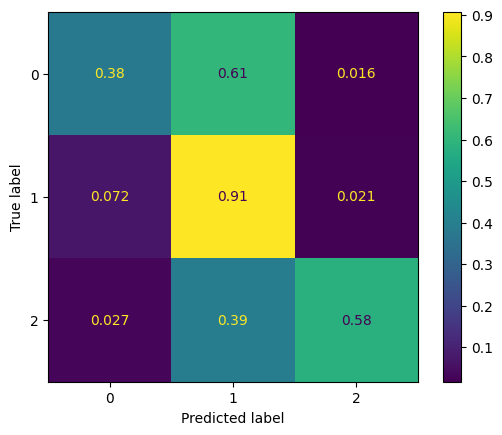

In [319]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    enable_categorical=True,   # <-- activa el manejo nativo
    n_jobs=-1
)

xgb_clf.fit(X_train_res, y_train_res)
y_pred = xgb_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()                                                              

### Random Forest

Accuracy: 0.7906066536203522

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.39      0.43        61
           1       0.83      0.91      0.87       376
           2       0.80      0.53      0.63        74

    accuracy                           0.79       511
   macro avg       0.70      0.61      0.64       511
weighted avg       0.78      0.79      0.78       511



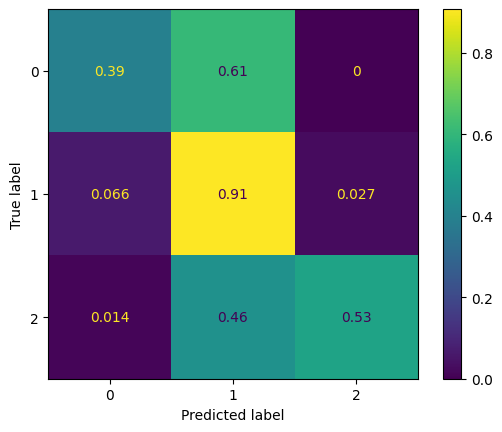

In [320]:
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train_res, y_train_res)
y_pred = rf_clf.predict(X_test)

# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()

### Decision Tree Classifier

Accuracy: 0.7553816046966731

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.43      0.42        61
           1       0.82      0.86      0.84       376
           2       0.65      0.47      0.55        74

    accuracy                           0.76       511
   macro avg       0.63      0.59      0.60       511
weighted avg       0.75      0.76      0.75       511



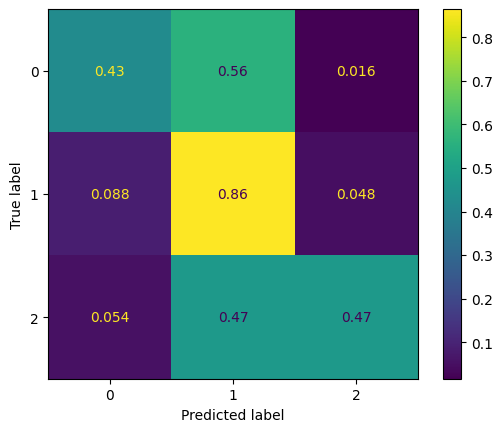

In [321]:
# Definir árbol de decisión
dt_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=None  # puedes ajustar para evitar overfitting
)
dt_clf.fit(X_train_res, y_train_res)
y_pred = dt_clf.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp_pre = ConfusionMatrixDisplay(cm, display_labels=[0,1,2])
disp_pre.plot()

### Gradient Boosting

Accuracy: 0.7945205479452054

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.38      0.41        61
           1       0.83      0.91      0.87       376
           2       0.82      0.57      0.67        74

    accuracy                           0.79       511
   macro avg       0.70      0.62      0.65       511
weighted avg       0.79      0.79      0.79       511



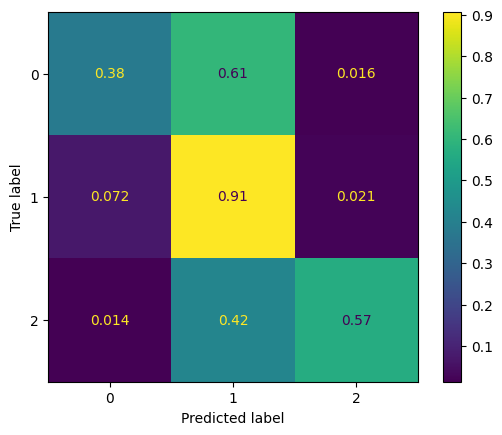

In [322]:
gb_clf = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gb_clf.fit(X_train_res, y_train_res)
y_pred = gb_clf.predict(X_test)
# Métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Matriz de confusión
disp_pre = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='true'), display_labels=[0,1,2])
disp_pre.plot()